# Steps
* Auxiliary Functions:
    * Interpolation Functions - Ok
    * Boostrapping - Basic boostrapper, sin dual curve y sin otros productos
    * Estimating Correlations
    * Black Pricing Formula - ok, solo como funcion
    
* Interest Rate Modeling:
    * Seting-up LMM
    * Calibrating to Cap/Floors Vols - volatility stripping, revisar, ** falta ajustar vol por sqrt(T-t)

* CVA
    * Boostrapping Default Probablities
    * Getting E[MTM]


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm
from scipy.stats import random_correlation

#For parametric volatility fitting
from scipy.optimize import minimize
from scipy.interpolate import CubicSpline
pd.options.display.float_format = '{:,.4f}'.format

In [2]:
class Interpolator:
    def __init__(self,x,y,kernel='linear',extrapolate=True):
        self.kernel = kernel
        self.ex = extrapolate
        self.x = x
        self.y = y
    def __call__(self, x_hat):
        if self.kernel == 'linear':
            interpolator = self.__linear_interpolation
        elif self.kernel == 'MCS':
            interpolator = self.__MCS_interpolation
        else:
            raise ValueError('Unsupported kernel.')
        
        if isinstance(x_hat,(np.ndarray, np.generic)):
            if x_hat.size>0:
                f = np.vectorize(interpolator)
                return f(x_hat)
            else:
                return interpolator(x_hat)
        else:
            return interpolator(x_hat)
        
    def __linear_interpolation(self, x_hat):
        if x_hat>self.x[-1]:
            if self.ex ==True:
                return self.y[-2] + (x_hat-self.x[-2])/(self.x[-1]-self.x[-2])*(self.y[-1]-self.y[-2])
            else:
                raise ValueError('Extrapolation not enabled.')
        else:    
            pos = np.searchsorted(self.x,x_hat)-1
            a = ((x_hat - self.x[pos])/(self.x[pos+1]-self.x[pos]))*self.y[pos+1]
            b = ((self.x[pos+1] - x_hat)/(self.x[pos+1]-self.x[pos]))*self.y[pos]
            return a+b
    def __MCS_interpolation(self, x_hat):
        if x_hat == self.x[-1]:
            return self.y[-1]
        
        if x_hat>self.x[-1]:
            if self.ex ==True:
                return self.y[-2] + (x_hat-self.x[-2])/(self.x[-1]-self.x[-2])*(self.y[-1]-self.y[-2])
            else:
                raise ValueError('Extrapolation not enabled.')
        else:  
            pos = np.searchsorted(self.x,x_hat)-1
            if self.x[pos+1]==x_hat:
                pos +=1

            y_0 = self.__y(-1,pos)
            y_1 = self.__y(0,pos)
            s =  (self.y[pos+1]-self.y[pos])/(self.x[pos+1]-self.x[pos])
            c = (3*s-2*y_0-y_1)/(self.x[pos+1]-self.x[pos])
            d = (y_1+y_0-2*s)/(self.x[pos+1]-self.x[pos])**2
            y_hat = self.y[pos]+y_0*(x_hat-self.x[pos])+c*(x_hat-self.x[pos])**2-d*(x_hat-self.x[pos])**3
            return y_hat
    def __y(self,idx,pos):
        #y(0) -> y'_i
        #y(1) -> y'_i+1
        h_i = self.x[pos+1+idx] - self.x[pos+idx]
        h_i_1 = self.x[pos+idx] - self.x[pos+idx-1] #h_i-1
        dy = self.y[pos+idx+1] - self.y[pos+idx]
        d_i = dy/h_i
        d_i_1 = dy/h_i_1 #d_i-1
        if np.sign(d_i)==np.sign(d_i_1):
            y_hat = 3*(h_i_1+h_i)*((2*h_i+h_i_1)/d_i_1+(h_i+2*h_i_1)/d_i)**-1
        else:
            y_hat = 0
        return y_hat


## Basic Curves

#### Comentarios:
    - Asume year fraction de 0.5 fijo.

In [3]:
ois_data = pd.read_excel('project_data.xlsx',sheet_name='ois', index_col='T')
ois_rates = ois_data['Rate'].values/100
T_ois = ois_data.index.values
ois_interp = Interpolator(T_ois,ois_rates)

libor_data = pd.read_excel('project_data.xlsx',sheet_name='libor', index_col='T')
libor_rates = libor_data['Rate'].values/100
T_libor = libor_data.index.values

libor_interp = CubicSpline(T_libor,libor_rates)

In [4]:
libor_data

,Maturity,Rate,Unnamed: 3,Unnamed: 4,Libors,Rate.1
T,,,,,,
0.0028,2019-12-09,1.9060,nan,nan,3M,1.9000
0.2778,2020-03-18,1.8630,nan,nan,6M,1.9060
0.5306,2020-06-17,1.8003,nan,nan,NaN,nan
0.7833,2020-09-16,1.7471,nan,nan,NaN,nan
1.0361,2020-12-16,1.7006,nan,nan,NaN,nan
1.2889,2021-03-17,1.6695,nan,nan,NaN,nan
1.5417,2021-06-16,1.6393,nan,nan,NaN,nan
2.0222,2021-12-06,1.6292,nan,nan,NaN,nan
3.0333,2022-12-05,1.5991,nan,nan,NaN,nan


In [5]:
class Curve:
    def discount(self,t):
        return 1/(1+self.zero_interp(t)*t)
    def forward_rate(self,t, T):
        df_T = self.discount(T)
        df_t = self.discount(t)
        return (df_t/df_T-1)/(T-t)  

class BasicSwapCurve(Curve):
    def __init__(self, rate_interpolator, up_to=30):
        self.rate_interp = rate_interpolator
        self.upto = up_to
    def boostrap(self):
        #zero rates
        t = np.arange(0.5,self.upto+0.5,0.5)        
        df = [1/(1+self.rate_interp(0.5*i)*0.5*i) for i in range(1,4)]    
        for i in range(3,self.upto*2):
            r = self.rate_interp(t[i])
            df_T = (1-r*0.5*np.sum(df))/(r*0.5+1)
            df.append(df_T)
            
        df = np.array(df)    
        self.zero_rates = (1/df-1)*(1/t)
        self.zero_interp = Interpolator(t,self.zero_rates)        

class ZeroCurve(Curve):
    def __init__(self, rate_interpolator):
        self.zero_interp = rate_interpolator

In [6]:
ois_curve = BasicSwapCurve(ois_interp,up_to=10)
ois_curve.boostrap()

libor_curve = BasicSwapCurve(libor_interp,up_to=10)
libor_curve.boostrap()

In [7]:
print(libor_curve.zero_interp(2))
libor_interp(2)

0.0164851830536058


array(0.01629181)

In [8]:
T = 10
t = np.arange(0.5,T+0.5,0.5)
print(libor_interp(T))
(1-libor_curve.discount(t[-1]))/(0.5*np.sum(libor_curve.discount(t)))


0.017427604391044703


0.01742760439104472

## Volatility

#### Comentarios:
    - Falta comprobar si esta OK la funcion implementada.
    - Existen mas funciones.

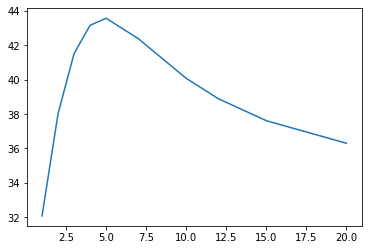

In [9]:
cap_vols= pd.read_excel('project_data.xlsx',sheet_name='cap_vol', index_col='Expiry')
plt.plot(cap_vols['ATM'])
plt.show()

cap_T = cap_vols.index.values
cap_vol = cap_vols['ATM'].values/100

vol_interp = Interpolator(cap_T,cap_vol)

In [10]:
class ParametricVolatility:
    def __init__(self,kernel='time to maturity',params = None):
        self.kernel = kernel
        if params:
            self.params = params    
    def fit(self,T,vol, display=False):
        if self.kernel == 'time to maturity': 
            f = lambda x: np.sum((vol-self.time_to_maturity_vol(T,0,x))**2)            
            x0 = np.array([0,0,0,0])
            res = minimize(f,x0, method='Nelder-Mead',options={'xtol': 1e-8, 'disp': display,'maxiter':10000})            
            self.params = res.x
        return self.params
    def __call__(self,t,T):
        if self.kernel == 'time to maturity':
            return self.time_to_maturity_vol(t,T,self.params)
    def time_to_maturity_vol(self,t,T,params):
        return (params[0]*(T-t)+params[3])*np.exp(-params[1]*(T-t))+params[2]

In [11]:
tmp = ParametricVolatility()
tmp.fit(cap_T,cap_vol)
T=np.arange(0,20.5,0.5)


## Black Formula

cap_vol = [0.29,0.38,0.42,0.4,0.38]
cap_T = [1.02,2.03,3.04,4.05,5.075]

vol_interp = Interpolator(cap_T,cap_vol)

rates = np.array([0.01,0.09,0.3,0.7,1.07,1.71])/100
t = np.array([0.25,0.5,1,2,3,5])
rate_interp = Interpolator(t,rates)
curve = ZeroCurve(rate_interp)

In [12]:
ois_data = pd.read_excel('test_data.xlsx',sheet_name='ois', index_col='T')
ois_rates = ois_data['Rate'].values/100
T_ois = ois_data.index.values
ois_interp = Interpolator(T_ois,ois_rates)

libor_data = pd.read_excel('test_data.xlsx',sheet_name='libor', index_col='T')
libor_rates = libor_data['Rate'].values/100
T_libor = libor_data.index.values
libor_interp = CubicSpline(T_libor,libor_rates)

ois_curve = ZeroCurve(ois_interp)
libor_curve = ZeroCurve(libor_interp)

cap_vol = pd.read_excel('test_data.xlsx',sheet_name='Quotes', index_col='Tenor')
cap_T = cap_vols.index.values
cap_vol = cap_vols['ATM'].values/100
vol_interp = Interpolator(cap_T,cap_vol)

In [13]:
class StripHelpers:
    def __init__(self, data):
        self.data = data
    def swap_rate(self,T):
        proy_curve = data['proy_curve']
        disc_curve = data['disc_curve']
        
        t = np.arange(0.5,T+0.5,0.5)
        f = proy_curve.forward_rate(t-0.5,t)
        df = disc_curve.discount(t)
        swap_rate = (1-df[-1])/(0.5*np.sum(df))        
        return swap_rate
    
    def black_price(self,t,T,f,k,vol_t,op_type='caplet'):
        #f: forward rate up to time T
        if op_type == 'caplet':
            w = 1
        elif op_type=='floorlet':
            w = -1
        d1 = (np.log(f/k)+(0.5*(vol_t)**2)*(T-t))/(vol_t*np.sqrt(T-t))    
        d2 = (np.log(f/k)-(0.5*(vol_t)**2)*(T-t))/(vol_t*np.sqrt(T-t)) 
        return f*w*norm.cdf(w*d1)-k*w*norm.cdf(w*d2)
   
    def cap_price(self,T,k,vol):
        '''
            t: first caplet end date
            T: maturity date
            f: forward rate
            k: strike
            vol: vol
        '''
        disc_curve = data['disc_curve']
        proy_curve = data['proy_curve']
        price = 0
        coupons = np.arange(1,T+0.5,0.5)
        for c in coupons:
            f = proy_curve.forward_rate(c-0.5,c)
            bp = self.black_price(0,c,f,f,vol)*0.5  
            df = disc_curve.discount(c)
            price += df*bp
        return price
    
class VolStrip(StripHelpers):
    def __init__(self, T, data):
        super().__init__(data)
        self.T = T

    def strip(self,display=False):
        cap_vol = data['cap_vol'] 
        proy_curve = data['proy_curve']  
        t = np.arange(1,self.T+0.5,0.5)
        caplet_vol = [cap_vol(1)]
        f = [proy_curve.forward_rate(0.5,1)]
        for c in t:
            k_t = self.swap_rate(c)
            k_T = self.swap_rate(c+0.5)
            cap_t = self.cap_price(c,k_t,cap_vol(c)*np.sqrt(c-0.5))
            cap_T = self.cap_price(c+0.5,k_T,cap_vol(c+0.5)*np.sqrt(c))
            f.append(proy_curve.forward_rate(c,c+0.5))
            obj = lambda v: ((cap_T-cap_t) - self.cap_price(c+0.5,f[-1],v*np.sqrt(0.5)))**2
            res = minimize(obj, cap_vol(c), method='Nelder-Mead',options={'xtol': 1e-8, 'disp': display,'maxiter':10000})
            caplet_vol.append(res.x[0])
        return pd.DataFrame({'ATM Strike':f,'Caplet Vol':caplet_vol})

array([ 2.13944454e+00,  7.39539512e-03, -2.90664360e+02,  2.90997113e+02])

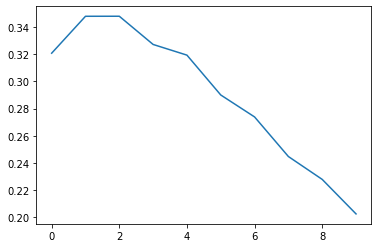

In [14]:
data = {'proy_curve':libor_curve, 'disc_curve': ois_curve, 'cap_vol':vol_interp}
irp = VolStrip(data=data,T=5)
plt.plot(irp.strip()['Caplet Vol'])
caplet_vol = irp.strip()['Caplet Vol']
caplet_T = np.arange(0.5,5.5,0.5)
parametric_vol = ParametricVolatility()
parametric_vol.fit(caplet_T,caplet_vol)

In [15]:
parametric_vol(0.49,0.5)

0.33262695268183506

## Libor Market Model

In [22]:
n_sim = 1000

last_tenor = 5
tenors = np.arange(0.5,last_tenor+0.5,0.5)
time_steps = np.arange(dt,tenors[-1]+dt,dt)
f0 = libor_curve.forward_rate(tenors-0.5,tenors)*100

f = np.zeros(shape=(time_steps.shape[0]+1,tenors.shape[0],n_sim))
L = np.zeros_like(f)
tau = 0.5
p = rho[-1,:]

NameError: name 'dt' is not defined

In [16]:
spot_data = {'ois_rates':ois,
            'libor_rates':libor,
            'vol_rates': vol,
            'cor_matrix': rho}

options = {'r_interp':  'linear',
           'df_interp': 'linear',
           'vol_func': 'parametric'
           'dt' =       0.5}

model = LiborMarketModel(spot_data, options)
model.simulate()
E_mtm =  model.price(swap)

SyntaxError: invalid syntax (<ipython-input-16-c0bcaea2b1eb>, line 9)

In [17]:
class LiborMarketModel:
    def __init__(self, options):
        self.dt = options['dt']
        self.vol_func = options['vol_func']
        self.df_interp = options['df_interp']
        self.r_interp = options['r_interp']
    def calibrate(self, spot_data):
        
        #Input: forward rates, cap volatilities and correlation matrix
        self.libor_r = spot_data['libor_rates']
        self.ois_r = spot_data['ois_rates']
        self.vol_r = spot_data['vol_rates']
        self.rho = spot_data['cor_matrix']
        
        
    def simulate(self, n_sim, seed = 1):
        np.random.seed(seed)
        #tmp = np.random.rand(10)
        #tmp = tmp/np.sum(tmp)*10
        #rho = random_correlation.rvs(tmp)
        
        last_tenor = 5
        tenors = np.arange(0.5,last_tenor+0.5,0.5)
        time_steps = np.arange(dt,tenors[-1]+dt,dt)
        f0 = libor_curve.forward_rate(tenors-0.5,tenors)*100

        f = np.zeros(shape=(time_steps.shape[0]+1,tenors.shape[0],n_sim))
        L = np.zeros_like(f)

        p = self.rho[-1,:]
        for k in tqdm(range(n_sim)):   
            f[0,:,k] = f0
            for i, t in enumerate(time_steps):      
                live_T = tenors>t
                vol = parametric_vol(t,tenors[live_T])
                p = rho[-1,:][live_T]   
                phi = np.random.normal(size=p.shape[0])
                dZ = phi
                f_k = f[i,:,k][live_T]       

                #first drift
                tmp = (tau*vol[1:]*f_k[1:]*p[1:])/(1+tau*f_k[1:])
                tmp = np.append(tmp,0) #terminal measure has 0 drift        
                u_k_1 = np.flipud(np.flipud(tmp).cumsum())    

                df = (u_k_1 - 0.5*vol**2)*dt+vol*np.sqrt(dt)*dZ
                f_k_ = f_k*np.exp(df)
                #if a forward rate has matured, adapt array size

                #second drift
                tmp = (tau*vol[1:]*f_k_[1:]*p[1:])/(1+tau*f_k_[1:])
                tmp = np.append(tmp,0) #terminal measure has 0 drift        
                u_k_2 = np.flipud(np.flipud(tmp).cumsum())    

                u_k = (u_k_1+u_k_2)/2

                f[i+1,:,k][live_T] = f_k*np.exp(df)
        f[f==0] = np.nan   
        return f

In [18]:
#spot_data = {'ois_rates':ois,
#            'libor_rates':libor,
#            'vol_rates': vol,
#            'cor_matrix': rho}

options = {'r_interp':  {'kernel':'linear', 'extrapolate':True},
           'df_interp': {'kernel':'linear', 'extrapolate':True},
           'vol_funct': 'parametric',
           'n_sim':     1000,
           'dt':        0.5}
m = LiborMarketModel(options)

KeyError: 'vol_func'

In [ ]:
plt.plot(f[1,:,:])
plt.show()

In [23]:
from mpl_toolkits.mplot3d import Axes3D
s = 1
fig = plt.figure(figsize=(10,10))
X, Y = np.meshgrid(tenors,time_steps)
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, f[1:,:,s]*100, cmap='viridis',edgecolor='green')
ax.view_init(40, 90)
plt.show()

NameError: name 'time_steps' is not defined

<Figure size 720x720 with 0 Axes>

In [19]:
df = pd.read_excel(r'C:\Users\jmelo\OneDrive\Escritorio\Pega\cqf\final_project\project_data.xlsx',sheet_name='historical f', index_col='Date')
cor = CorrelationReduction(df)
cor.rank_reduction()
pd.DataFrame(cor.B)
dZ = cor.correlated_dZ()
pd.DataFrame(dZ[:,:,0])

NameError: name 'CorrelationReduction' is not defined

In [ ]:
model

In [20]:
class Swap6M:
    def __init__(self,years,side):
        self.y = years
        self.side = side
        self.coupon = 0
    def set_eval_date(self, t):
        self.t=t
        #Condiciones originales
        self.yf = np.arange(0.5,self.y+0.5,0.5)
        if t in self.yf:
            self.coupon = 1
        else:
            self.coupon = 0
        self.acc_yf = np.full(self.y*2,0.5)
        self.yf = self.yf - t
        time = (self.yf>0)
        self.yf = self.yf[time]
        paid = np.size(time)-np.count_nonzero(time)
        self.acc_yf = self.acc_yf[time]
        return 0
    @property
    def fixed_rate(self):
        return self._fixed_rate
    @fixed_rate.setter
    def fixed_rate(self, arg):
        self._fixed_rate = arg
class IRS(Swap6M):
    def __init__(self, years, model,side=1):
        super().__init__(years,side)
        self.model = model
        self.par_rate()
    def par_rate(self):
        self.set_eval_date(0)
        fwd = self.model.f[0,0:self.acc_yf.shape[0],0]
        df = self.model.P_OIS[0,0:self.acc_yf.shape[0],0]
        self.fixed_rate = np.sum(self.acc_yf*fwd*df)/np.sum(self.acc_yf*df)
        mtm = np.sum(0.5*fwd*df)+df[-1] - self.fixed_rate*np.sum(0.5*df) - df[-1]
        return self.fixed_rate
    def get_mtm(self):
        f = self.model.f
        dfs = self.model.P_OIS
        dt = self.model.dt
        mtm = np.zeros(shape=(self.acc_yf.shape[0]+1,1,f.shape[2]))
        for i in range(self.acc_yf.shape[0]+1):
            self.set_eval_date(dt*i)
            for j in range(f.shape[2]):
                df = dfs[i,:,j]
                df = df[df!=np.nan][i:i+self.acc_yf.shape[0]]
                fwd = f[i,:,j]
                fwd = fwd[fwd!=np.nan][i:i+self.acc_yf.shape[0]]
                if self.side == 0:
                    mtm[i,0,j] = self.fixed_rate*np.sum(self.acc_yf*df) - np.sum(self.acc_yf*fwd*df)
                else:
                    mtm[i,0,j] = -self.fixed_rate*np.sum(self.acc_yf*df) + np.sum(self.acc_yf*fwd*df)
        return mtm

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, r'C:\Users\jmelo\OneDrive\Escritorio\Pega\cqf\final_project\scripts')
from ratemodels import *

In [22]:
model = simulated_model(n_sim=90000)

TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [73]:
pd.DataFrame(model.f[:,:,0])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.0191,0.0162,0.0163,0.0161,0.0165,0.0166,0.0171,0.0176,0.0178,0.0181,0.0185,0.0188,0.0191,0.0194,0.0197,0.0201,0.0204,0.0208,0.0211,0.0213
1,nan,0.0181,0.0205,0.0209,0.0242,0.0246,0.0256,0.0261,0.0263,0.0264,0.0271,0.0272,0.0277,0.0279,0.0281,0.0285,0.0280,0.0282,0.0291,0.0293
2,nan,nan,0.0201,0.0175,0.0190,0.0185,0.0188,0.0191,0.0192,0.0195,0.0199,0.0201,0.0206,0.0208,0.0213,0.0216,0.0216,0.0218,0.0222,0.0224
3,nan,nan,nan,0.0202,0.0263,0.0277,0.0297,0.0304,0.0306,0.0305,0.0313,0.0312,0.0317,0.0316,0.0318,0.0319,0.0307,0.0307,0.0317,0.0317
4,nan,nan,nan,nan,0.0277,0.0286,0.0293,0.0291,0.0280,0.0275,0.0274,0.0270,0.0275,0.0273,0.0277,0.0276,0.0269,0.0268,0.0270,0.0268
5,nan,nan,nan,nan,nan,0.0282,0.0269,0.0259,0.0248,0.0245,0.0247,0.0246,0.0251,0.0251,0.0255,0.0256,0.0251,0.0251,0.0254,0.0253
6,nan,nan,nan,nan,nan,nan,0.0243,0.0198,0.0177,0.0171,0.0172,0.0175,0.0181,0.0186,0.0193,0.0197,0.0196,0.0198,0.0202,0.0203
7,nan,nan,nan,nan,nan,nan,nan,0.0203,0.0177,0.0167,0.0165,0.0166,0.0172,0.0176,0.0184,0.0187,0.0187,0.0189,0.0192,0.0192
8,nan,nan,nan,nan,nan,nan,nan,nan,0.0204,0.0214,0.0217,0.0218,0.0224,0.0223,0.0228,0.0228,0.0226,0.0224,0.0221,0.0219
9,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0239,0.0269,0.0281,0.0295,0.0295,0.0299,0.0295,0.0282,0.0277,0.0276,0.0270


In [85]:
swap = IRS(years=10, model=model, side=1)
mtm = swap.get_mtm()
pd.DataFrame(mtm[:,0,:])

,0,1,2,3,4,5,6,7,8,9,...,89990,89991,89992,89993,89994,89995,89996,89997,89998,89999
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0625,-0.0267,-0.0037,-0.0424,-0.0199,0.0838,-0.0218,-0.0098,0.0152,-0.0181,...,0.0584,-0.0078,-0.0047,0.0613,-0.0099,-0.0064,0.0365,-0.0038,0.0575,0.0198
2,0.0142,-0.0373,0.0788,-0.0053,-0.0571,0.0430,-0.0127,-0.0343,0.0392,0.0187,...,0.0434,0.0109,-0.0182,0.1465,0.0105,0.0274,0.0489,-0.0161,-0.0200,0.0153
3,0.0861,-0.0072,0.1660,0.0124,-0.0409,0.0429,0.0081,-0.0500,0.0893,0.0053,...,-0.0447,0.0531,-0.0285,0.0608,0.0601,0.0134,0.0042,-0.0344,-0.0545,0.0157
4,0.0662,-0.0443,0.2215,0.0053,-0.0662,0.0140,0.0182,-0.0618,0.0443,-0.0284,...,-0.0525,0.0240,-0.0152,0.0119,0.0351,-0.0184,-0.0400,-0.0687,-0.0236,-0.0129
5,0.0479,-0.0446,0.1363,0.0698,-0.1010,0.0674,0.0510,-0.0467,0.0188,0.0060,...,-0.0874,0.0271,-0.0261,-0.0329,0.0305,0.0292,-0.0268,-0.0834,-0.0180,0.0151
6,0.0051,-0.0754,0.0906,0.0043,-0.1049,0.0967,0.0592,-0.0494,-0.0145,0.0428,...,-0.0848,-0.0280,-0.0225,-0.0321,0.0712,0.0325,-0.0464,-0.0765,-0.0621,0.0028
7,-0.0020,-0.0720,0.1145,0.0150,-0.0951,0.0658,-0.0046,-0.0403,-0.0418,0.0113,...,-0.0819,-0.0216,-0.0306,-0.0365,0.0351,0.0015,-0.0312,-0.0499,-0.0609,0.0913
8,0.0202,-0.0706,0.0909,0.0350,-0.0958,0.0290,-0.0010,-0.0611,-0.0399,-0.0014,...,-0.0782,-0.0303,-0.0527,-0.0595,0.0229,0.0210,-0.0449,-0.0482,-0.0681,0.0483
9,0.0484,-0.0644,0.0989,0.0028,-0.0886,0.0343,0.0121,-0.0633,-0.0432,-0.0465,...,-0.0795,-0.0371,-0.0337,-0.0570,0.0572,-0.0014,-0.0323,-0.0468,-0.0605,0.0370


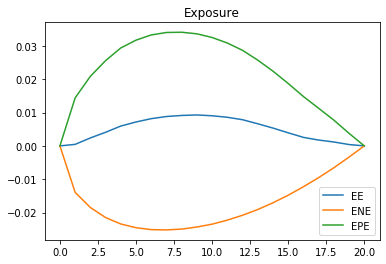

In [86]:
EPE = mtm.copy()
EPE[EPE<0] = 0
ENE = mtm.copy()
ENE[ENE>0] = 0

EE = [np.mean(mtm[i,0,:]) for i in range(mtm.shape[0])]
ENE = [np.mean(ENE[i,0,:]) for i in range(ENE.shape[0])]
EPE = [np.mean(EPE[i,0,:]) for i in range(EPE.shape[0])]

plt.figure(0)
plt.title('Exposure')
plt.plot(EE, label='EE')
plt.plot(ENE, label='ENE')
plt.plot(EPE, label='EPE')
plt.legend(loc='lower right')
plt.show()

In [87]:
mtm[1,:,:].mean()

0.00045268893680055816

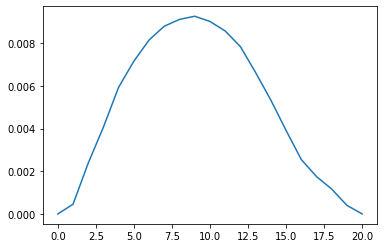

In [88]:
e_mtm = [np.mean(mtm[i,0,:]) for i in range(mtm.shape[0])]
e_mtm[1:][e_mtm==0] = np.nan
plt.plot(e_mtm)
plt.show()

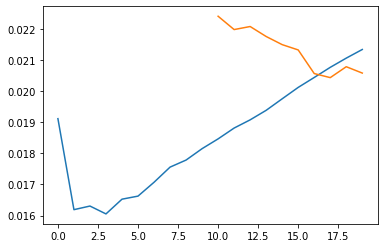

In [100]:
plt.plot(model.f[0,:,0])

plt.plot(np.mean(model.f[10,:,:],axis=1))


In [52]:
model.P_OIS[:,:,0]

array([[0.99234418, 0.98515902, 0.97846303, 0.97157658, 0.96482267,
        0.95811666, 0.9509569 , 0.94335328, 0.93591456, 0.92845385,
        0.92087116, 0.91319165, 0.9054305 , 0.89760668, 0.88972971,
        0.88178449, 0.87378091, 0.86573194, 0.8576524 , 0.84955885],
       [       nan, 0.99180631, 0.98302037, 0.97375952, 0.96333408,
        0.95288397, 0.94176717, 0.93029498, 0.91907278, 0.90802124,
        0.89677758, 0.88560814, 0.87435989, 0.86317747, 0.85205973,
        0.84097612, 0.83023172, 0.81955565, 0.80869939, 0.79793763],
       [       nan,        nan, 0.99133866, 0.9836528 , 0.97563535,
        0.96795683, 0.95988731, 0.95147137, 0.94330554, 0.93517216,
        0.92688989, 0.91855335, 0.91006307, 0.90154821, 0.89293039,
        0.88428714, 0.87577213, 0.867266  , 0.85869212, 0.85016005],
       [       nan,        nan,        nan, 0.99092025, 0.97927502,
        0.9671363 , 0.95392326, 0.94029089, 0.92696682, 0.91396271,
        0.90075215, 0.88780528, 0.87478335, 0